# Aggregate Prediction Results

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

from rdkit.Chem import AllChem

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

import re
def has_int(s):
    patt = re.compile("(\d)")
    return any(re.findall(patt, s))

from ast import literal_eval

from DOV import get_smiles_DOV
import pickle as pk


# Load Data + Define Functions

In [2]:
%%capture
def calc_mw(smile):
    return Chem.rdMolDescriptors.CalcExactMolWt(
        Chem.MolFromSmiles(smile))

def get_max_mw(smiles):
    smiles = literal_eval(smiles)
    if isinstance(smiles, tuple):
        mws = [calc_mw(smiles[0])]
    else:
        mws = [calc_mw(s[0]) for s in smiles]
        
    return max(mws)

results_list = []

for res in glob.glob("./results/*.csv"):
    df_temp = pd.read_csv(res)
    results_list.append(df_temp)
    
max_mw = 100000
df_results = pd.concat(results_list)

kfolds_DOV_dict = pk.load(
    open("mn_only_kfolds_DOV_dict.pk", "rb")
)

df_results = df_results.iloc[::5, :]
df_agg = df_results.groupby(by=["smiles_polymer", "id", "pm", "distribution", "monomers"]).aggregate("mean")
df_agg = df_agg.reset_index()
df_agg.loc[:, "max_mw"] = df_agg.monomers.map(get_max_mw)
df_agg.loc[:, "Tm_min_Tg"] = df_agg.Tm_pred - df_agg.Tg_pred

df_DOV = df_agg[
    (
        (df_agg.distribution == "[]") | (df_agg.distribution == "[0.5, 0.5]")
        & (df_agg.max_mw <= max_mw)
    )
].copy()

df_DOV["num_missing"] = df_DOV.apply(lambda row: 
         get_smiles_DOV(row.smiles_polymer, row.pm, kfolds_DOV_dict), axis=1
        )

# Identify Number of Homo/Copo

In [4]:
from itertools import combinations
ddf = pd.read_csv("220523_PHA_copo.csv")
print("Homo: ", len(ddf[ddf.distribution.isna()])/5) # [0, 0.25, 0.5, 0.75, 1])
print("Copo: ", len([*combinations([i for i in range(80)], 2)]))
print("Total: ", (80+3160)*3)

Homo:  80.0
Copo:  3160
Total:  9720


In [3]:
ddf[ddf.distribution.isna()][~ddf[ddf.distribution.isna()].duplicated("smiles_monomer")]

NameError: name 'ddf' is not defined

# Plot Fish

/var/folders/mn/k32kn37x5ldgpp51c6cdmkpm0000gn/T/ipykernel_38321/2383802092.py:24: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_lte, legend=True, s=s/30, hue="pm", palette=sns.color_palette())


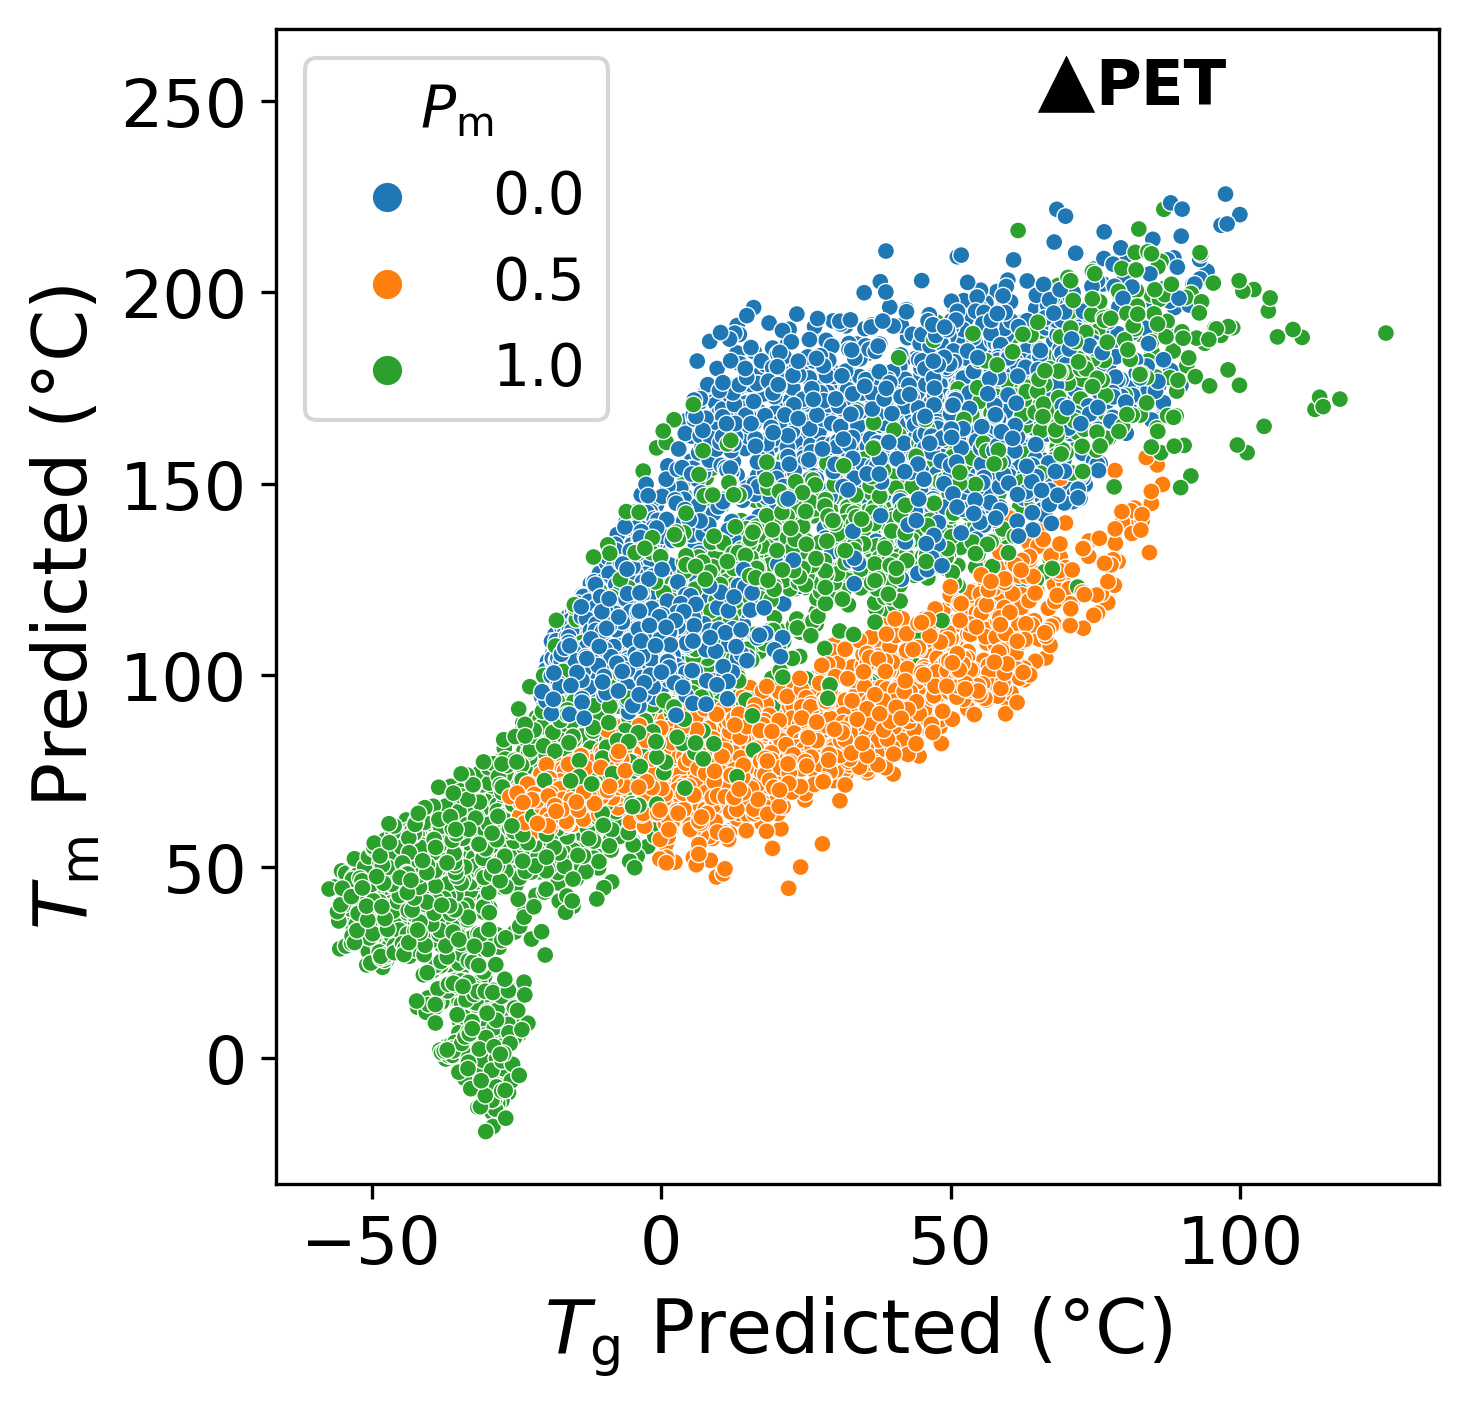

In [15]:
Tg_min = 60
Tg_max = 80

Tm_min = 150
Tm_max = 300

num_missing = 25
df_lte = df_DOV[df_DOV.num_missing <= num_missing]
df_lte = df_DOV[(df_DOV.pm != 0.25) & (df_DOV.pm != 0.75)]
# df_lte = df_DOV[df_DOV.pm != 0.75]
df = df_lte.copy()

# Plot Scatter
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
label_size = 18
tick_size = 16
legend_size = 14


s = 500

# orange, green, red = "#EE8536", "#519E3E", "#D52C23"
# colors = {0.0: red, 0.5: green, 1.0: orange}
sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_lte, legend=True, s=s/30, hue="pm", palette=sns.color_palette())
# sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_interest_co.iloc[[26, 36, 28], :], s=s, marker=(5, 1, 0), color="orange")
sns.scatterplot(x=[70], y=[255], marker="^", s=s/2, color="k")

# Label Markers
l_size = 15
dx, dy = (5, -5.8)
an_format = dict(fontsize=l_size, weight="bold")
ax.annotate('PET', xy=(70+dx-0.05, 255+dy), **an_format)
# ax.annotate('P1', xy=(60.43+dx, 192.45+dy), **an_format)
# ax.annotate('P2', xy=(69.22+dx, 192.72+dy), **an_format)
# ax.annotate('P3', xy=(71.99+dx, 190.03+dy), **an_format)

ax.set_xlabel("$T_\mathrm{g}$ Predicted (°C)", fontsize=label_size)
ax.set_ylabel("$T_\mathrm{m}$ Predicted (°C)", fontsize=label_size)
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

# Legend
plt.legend(title="$P_\mathrm{m}$", title_fontsize=legend_size, fontsize=legend_size, ncol=1)

# Save Figure
plt.savefig("../Figure_biopredictions.png", dpi=300, bbox_inches="tight")

# Find points Around Tail

# PET
Identify High T_m Monomers/Comonomers

<AxesSubplot:xlabel='Tg_pred', ylabel='Tm_pred'>

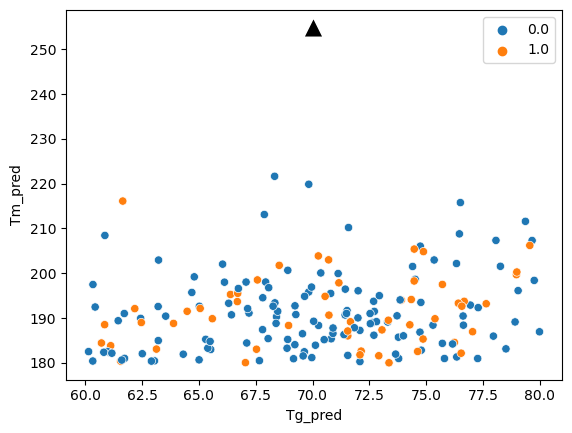

In [197]:
Tg_min = 60
Tg_max =80

Tm_min = 180
Tm_max = 1000


df_PET = df.copy()
df_PET = df_PET[
    (df_PET.Tg_pred > Tg_min)
    & (df_PET.Tg_pred < Tg_max)
    & (df_PET.Tm_pred > Tm_min)
    & (df_PET.Tm_pred < Tm_max)
    & ((df_PET.distribution == "[]") | (df_PET.distribution == "[0.5, 0.5]"))
#     & (df_PET.pm == 0)
]

sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_PET, legend=True, hue="pm")

# PVC
sns.scatterplot(x=[70], y=[255], marker="^", s=200, color="k")

### Loopp Through Monomers and Identify Good Ones
Record Good Ones Below

In [198]:
i = -1
df_PET = df_PET.sort_values(by="Tm_pred", ascending=False)

171
pm                    0.0
DP                   25.0
Tm_pred        181.542138
Tm_min_Tg      111.954454
num_missing            28
Name: 18468, dtype: object


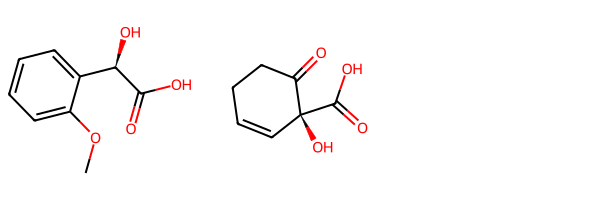

In [184]:
i+=1
monomers=[AllChem.MolFromSmiles(s) for s in get_mon_from_row(df_PET.iloc[i, :])]

print(i)
print(df_PET.iloc[i, [2, 5, 8, -2, -1]])
AllChem.Draw.MolsToGridImage(monomers)

In [199]:
good_monomers = [29, 37, 38, 54, 56, 68, 94, 107, 115, 157]
df_PET = df_PET.iloc[list(good_monomers), :].copy()
df_PET = df_PET.reset_index()

In [26]:
df_PET_syn.to_csv("PET_vals.csv", index=False)

## Investigate Good Molecules

In [214]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image as PILImage
from IPython.display import display

# Set the image size based on the number of molecules and their size
img_width = 300
img_height = len(df_PET) * 300

# Create a blank image with a white background
img = PILImage.new("RGB", (img_width, img_height), "white")

# Draw each molecule on the image
for idx, row in df_PET.iterrows():
    monomers = [AllChem.MolFromSmiles(s) for s in get_mon_from_row(row)]
    mol_img = AllChem.Draw.MolsToGridImage(monomers)
    img.paste(mol_img, (0, idx * 300))

# Save the image to a file or display it
display(img)

ValueError: cannot determine region size; use 4-item box

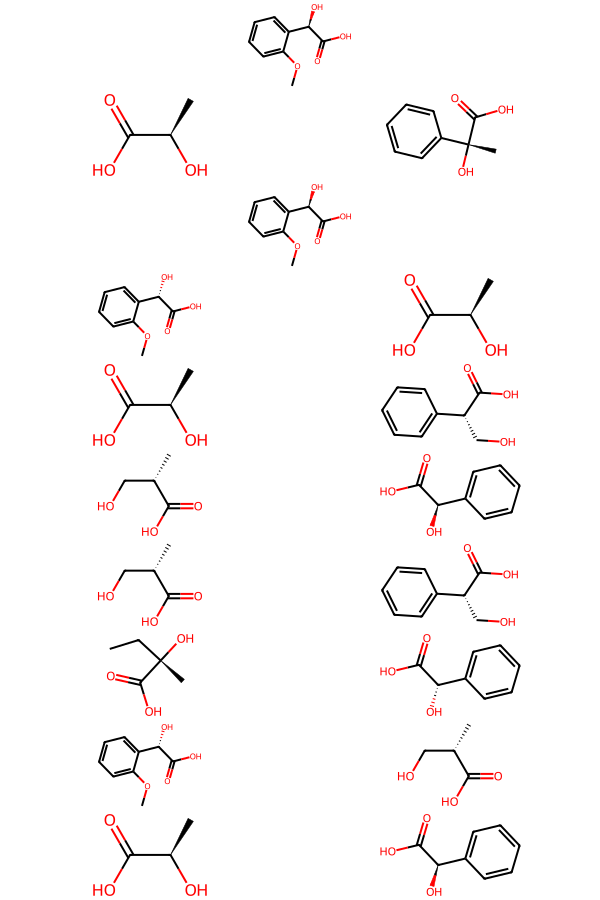

In [231]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image as PILImage
from IPython.display import display

# List of monomers in the form of pairs
monomer_pairs = []
for idx, row in df_PET.iterrows():
    monomers = [AllChem.MolFromSmiles(s) for s in sorted(get_mon_from_row(row))]
    monomer_pairs.append(monomers)

# monomer_pairs = [["CCO", "CC(C)(C)C(=O)O"], ["C1=CC=CC=C1"], ["CC(=O)O", "CC(C)C"]]

# # Create a list to store the RDKit molecules
# molecule_list = []

# # Convert SMILES strings to RDKit molecules
# for pair in monomer_pairs:
#     pair_molecules = [Chem.MolFromSmiles(smiles) for smiles in pair]
#     molecule_list.append(pair_molecules)

# Set the image size based on the number of pairs and their size
img_width = 600
img_height = 3 * 300  # Three rows

# Create a blank image with a white background
img = PILImage.new("RGB", (img_width, img_height), "white")

# Draw each pair of monomers on the image
row_height = img_height // len(monomer_pairs)
for idx, pair_molecules in enumerate(monomer_pairs):
    pair_img = PILImage.new("RGB", (img_width, row_height), "white")
    
    for mol_idx, mol in enumerate(pair_molecules):
        mol_img = Draw.MolToImage(mol, size=(img_width // 2, row_height))
        pair_img.paste(mol_img, (mol_idx*300, 0))
    
    img.paste(pair_img, (0 if len(pair_molecules) == 2 else img_width // 4, idx * row_height))

# Save the image to a file or display it
display(img)


### Analysis of Above
Lactic Acid, Glycolic Acid, Mandelic Acid, Tropic Acid, Methoxy Mendalic Acid

In [27]:
df_interest = df_PET.iloc[list(good_monomers), :].sort_values(by="Tm_pred", ascending=False)

### Monomers

In [37]:
df_interest_homo = df_interest[df_interest.distribution == "[]"].reset_index(drop=True)
df_interest_co = df_interest[df_interest.distribution == "[0.5, 0.5]"].reset_index(drop=True)

17
Tm_pred         202.955077
Tg_pred          75.352039
distribution    [0.5, 0.5]
pm                     0.0
Name: 18333, dtype: object
[['COc1ccccc1[C@@H](O)C(=O)O', 'COc1ccccc1[C@H](O)C(=O)O'], ['O=C(O)C1=CC(=O)[C@@H](O)C(=O)C1', 'O=C(O)C1=CC(=O)[C@H](O)C(=O)C1']]


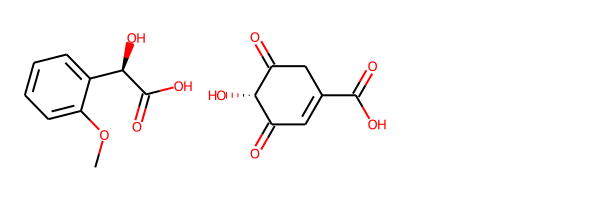

In [53]:
# i=0
i+=1
df_PET = df_PET.sort_values(by="Tm_pred", ascending=False).copy()
monomers = [
    AllChem.MolFromSmiles(s) for s in get_mon_from_row(df_PET.iloc[i, :])
]
print(i)
print(df_PET.iloc[i, [8, 9, 3, 2]])
print(df_PET.iloc[i, :].monomers)
AllChem.Draw.MolsToGridImage(monomers)


In [30]:
df_agg[df_agg.monomers == "[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['C[C@@](O)(C(=O)O)c1ccccc1', 'C[C@](O)(C(=O)O)c1ccccc1']]"]

,smiles_polymer,id,pm,distribution,monomers,DP,replicate_structure,Mn,Tm_pred,Tg_pred,kfold,max_mw,Tm_min_Tg
20294,C[C@@](O)(C(=O)O[C@@](C)(C(=O)O[C@](C)(C(=O)O[...,9143f56cf18a071863281cd29ef6a1aebdc1cf018dfcb1...,0.5,"[0, 1]","[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['C[...",25.0,0.0,1.0,123.413895,78.288019,5.0,166.062994,45.125876
20516,C[C@@](OC(=O)[C@](C)(O)c1ccccc1)(C(=O)O[C@@](C...,84b5c8505d9a9de56e3ac83f80f7ca0c0defd9c2051344...,0.0,"[0, 1]","[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['C[...",25.0,0.0,1.0,179.072513,88.460483,5.0,166.062994,90.612030
21245,C[C@H](O)C(=O)O[C@@H](C)C(=O)O[C@@H](C)C(=O)O[...,c5926e5bdf79fea68153643e1fc2c16976ae96e89ae3cc...,1.0,"[1, 0]","[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['C[...",25.0,0.0,1.0,189.181737,53.850807,5.0,166.062994,135.330930
21277,C[C@H](O)C(=O)O[C@@H](C)C(=O)O[C@@](C)(C(=O)O[...,27f85e0dfad6b6c3c671a944e13e750b4c57c1c43d9b7a...,1.0,"[0.5, 0.5]","[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['C[...",25.0,0.0,1.0,197.856150,71.159847,5.0,166.062994,126.696303
21281,C[C@H](O)C(=O)O[C@@H](C)C(=O)O[C@H](C)C(=O)O[C...,5b21a65184a7b1e9ad067fa3354c0483a7f5861c04074a...,0.5,"[1, 0]","[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['C[...",25.0,0.0,1.0,43.332303,22.021014,5.0,166.062994,21.311289
21327,C[C@H](O)C(=O)O[C@H](C)C(=O)O[C@@H](C)C(=O)O[C...,78af6e85e0c29fc7693f513328a5b0c5f91470aa47d32f...,0.0,"[1, 0]","[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['C[...",25.0,0.0,1.0,159.244778,36.670115,5.0,166.062994,122.574663
22416,C[C@H](OC(=O)[C@@H](C)OC(=O)[C@H](C)OC(=O)[C@@...,7617fa09b87d9104d0ba50ee7f65bcc5a8b506e77cff05...,0.0,"[0.5, 0.5]","[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['C[...",25.0,0.0,1.0,164.528059,73.791663,5.0,166.062994,90.736396
22443,C[C@H](OC(=O)[C@H](C)OC(=O)[C@@](C)(OC(=O)[C@]...,8f0044fb6036207371f16c22ad98e3ee331d1d79f44151...,0.5,"[0.5, 0.5]","[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['C[...",25.0,0.0,1.0,96.372275,51.508379,5.0,166.062994,44.863896
22607,C[C@](O)(C(=O)O[C@@](C)(C(=O)O[C@@](C)(C(=O)O[...,5327acfb1c10c66135f60f889735c117c5d20f53f7dbfd...,1.0,"[0, 1]","[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['C[...",25.0,0.0,1.0,212.574878,82.477675,5.0,166.062994,130.097203


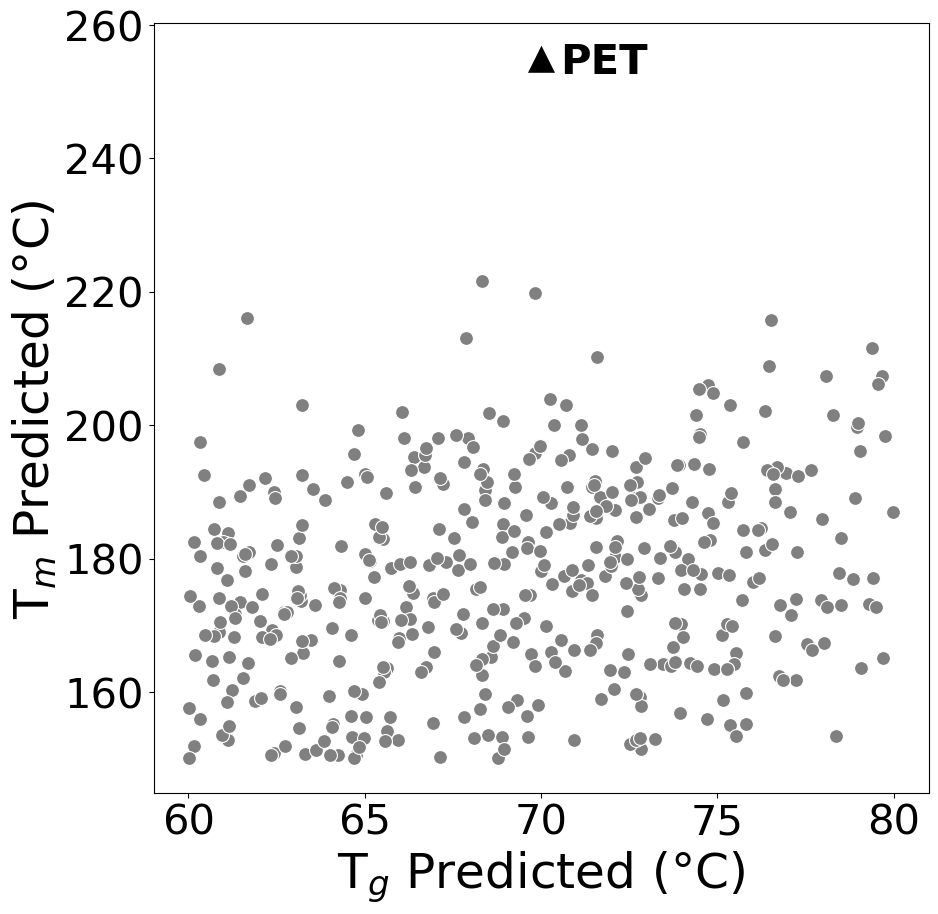

In [31]:
Tg_min = 60
Tg_max = 80

Tm_min = 150
Tm_max = 300


df_PET = df.copy()
df_PET = df_PET[
    (df_PET.Tg_pred > Tg_min)
    & (df_PET.Tg_pred < Tg_max)
    & (df_PET.Tm_pred > Tm_min)
    & (df_PET.Tm_pred < Tm_max)
    & ((df_PET.distribution == "[]") | (df_PET.distribution == "[0.5, 0.5]"))
]

# Plot Scatter
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

s = 1000
sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_PET, legend=True, s=s/10, color="grey", alpha=1)
# sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_interest_co.iloc[[26, 36, 28], :], s=s, marker=(5, 1, 0), color="orange")
sns.scatterplot(x=[70], y=[255], marker="^", s=s/2, color="k")

# Label Markers
l_size = 30
dx, dy = (0.6, -2.2)
an_format = dict(fontsize=l_size, weight="bold")
ax.annotate('PET', xy=(70+dx-0.05, 255+dy), **an_format)

# Axes Format
label_size = 35
tick_size = 30

ax.set_xlabel("T$_g$ Predicted (°C)", fontsize=label_size)
ax.set_ylabel("T$_m$ Predicted (°C)", fontsize=label_size)
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

# Save Figure
plt.savefig("PET.png", dpi=300, bbox_inches="tight")

# PET Plot

In [189]:
MA = [18187, 18293]
LA_MA = [17155]

mols_of_interest = MA+LA_MA



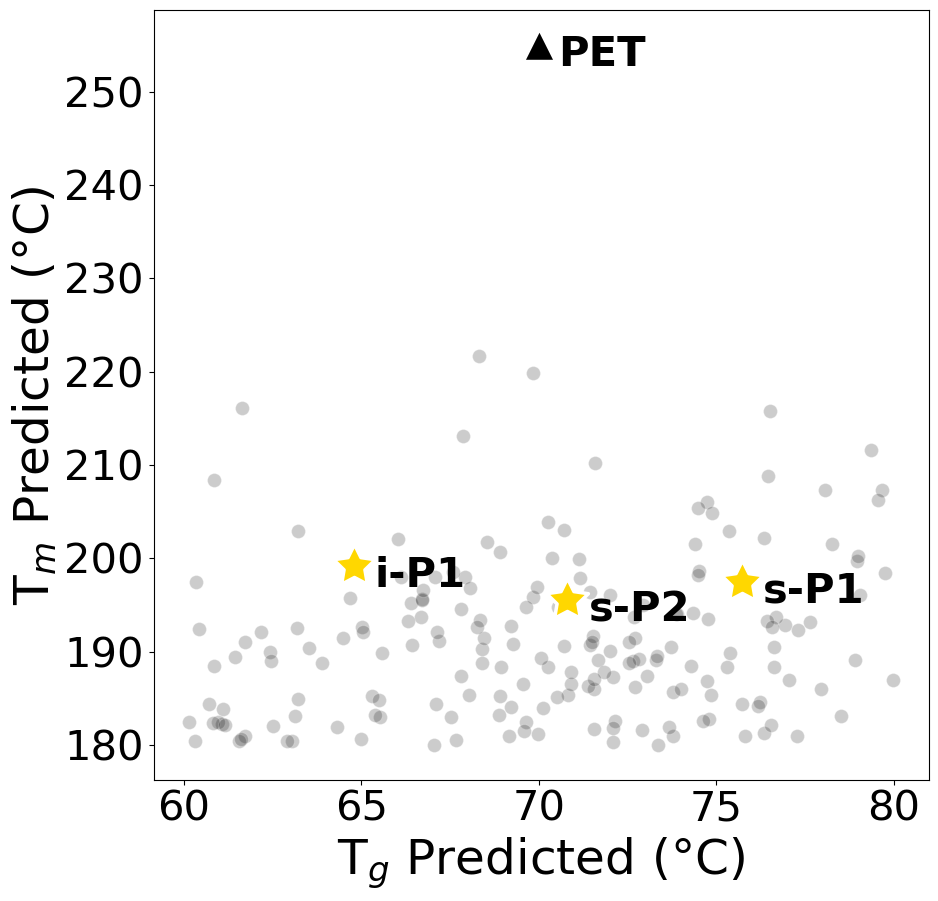

In [195]:
Tg_min = 60
Tg_max = 80

Tm_min = 180
Tm_max = 300

df_PET = df.copy()
df_PET = df_PET[
    (df_PET.Tg_pred > Tg_min)
    & (df_PET.Tg_pred < Tg_max)
    & (df_PET.Tm_pred > Tm_min)
    & (df_PET.Tm_pred < Tm_max)
    & ((df_PET.distribution == "[]") | (df_PET.distribution == "[0.5, 0.5]"))
#     & (df_PET.pm == 0)
]

# Plot Scatter
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
["#007a33", "#00a6de"]
s = 1000
sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_PET, legend=True, s=s/10, color="k", alpha=0.2)
sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_PET.loc[mols_of_interest, :], s=s, marker=(5, 1, 0), color="gold")#"#00a6de")
sns.scatterplot(x=[70], y=[255], marker="^", s=s/2, color="k")

# Label Markers
l_size = 30
dx, dy = (0.6, -2.2)
an_format = dict(fontsize=l_size, weight="bold")
ax.annotate('PET', xy=(70+dx-0.05, 255+dy), **an_format)

# MethoxyA
ax.annotate('i-P1', xy=(64.79+dx, 199.19+dy), **an_format) 
ax.annotate('s-P1', xy=(75.714185+dx, 197.495172+dy), **an_format) 

# non-synth
ax.annotate('s-P2', xy=(70.799524+dx, 195.492449+dy), **an_format) 

# PLA-MA
# ax.annotate('i-P3', xy=(74.6256+dx, 182.535662+dy), **an_format) 

# ax.annotate('PET', xy=(70+dx-0.05, 255+dy), **an_format)
# ax.annotate('P3', xy=(74.29+dx, 178.295+dy), **an_format)
# ax.annotate('P1', xy=(69.22+dx, 192.72+dy), **an_format)
# ax.annotate('P2', xy=(71.99+dx, 190.03+dy), **an_format)

# Axes Format
label_size = 35
tick_size = 30

ax.set_xlabel("T$_g$ Predicted (°C)", fontsize=label_size)
ax.set_ylabel("T$_m$ Predicted (°C)", fontsize=label_size)
ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)

# Save Figure
plt.savefig("../PET_and_two_highlighted.png", dpi=300, bbox_inches="tight")

In [566]:
list(df_PET.iloc[mols_of_interest, :].monomers)

["('COc1ccccc1[C@@H](O)C(=O)O', 'COc1ccccc1[C@H](O)C(=O)O')",
 "('COc1ccccc1[C@@H](O)C(=O)O', 'COc1ccccc1[C@H](O)C(=O)O')",
 "[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['O=C(O)[C@@H](O)c1ccccc1', 'O=C(O)[C@H](O)c1ccccc1']]",
 "[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=O)C(=O)O'], ['O=C(O)[C@@H](CO)c1ccccc1', 'O=C(O)[C@H](CO)c1ccccc1']]"]

In [570]:
df_PET.iloc[mols_of_interest, :]

,smiles_polymer,id,pm,distribution,monomers,DP,replicate_structure,Mn,Tm_pred,Tg_pred,kfold,max_mw,Tm_min_Tg,num_missing
18187,COc1ccccc1[C@H](O)C(=O)O[C@@H](C(=O)O[C@H](C(=...,4908655bb83d2b7a1901342cfe930cede43153573a3fea...,0.0,[],"('COc1ccccc1[C@@H](O)C(=O)O', 'COc1ccccc1[C@H]...",25.0,0.0,1.0,199.192811,64.797426,5.0,182.057909,134.395385,10
18293,COc1ccccc1[C@H](O)C(=O)O[C@H](C(=O)O[C@H](C(=O...,a4db50739f91218f8130952774ad25b991e0dd36c3dda3...,1.0,[],"('COc1ccccc1[C@@H](O)C(=O)O', 'COc1ccccc1[C@H]...",25.0,0.0,1.0,197.495172,75.714185,5.0,182.057909,121.780987,3
21209,C[C@H](O)C(=O)O[C@@H](C(=O)O[C@@H](C)C(=O)O[C@...,010af2eae9de3bd6ceabbe22d6d28d3a5780603b7b7fee...,1.0,"[0.5, 0.5]","[['C[C@@H](O)C(=O)O', 'C[C@H](O)C(=O)O'], ['O=...",25.0,0.0,1.0,182.535662,74.625618,5.0,152.047344,107.910044,0
17155,CC[C@](C)(O)C(=O)C(=O)OC[C@H](C(=O)OC[C@@H](C(...,17419e1cc9e63eea8c7bd3bc1d00ccb547959f94e69a89...,0.0,"[0.5, 0.5]","[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=...",25.0,0.0,1.0,195.492449,70.799524,5.0,166.062994,124.692925,21


In [80]:
# Get actual values
print(df_interest_co.iloc[[12, 15], :].monomers)
list(df_interest_co.iloc[[12, 15], :].monomers)[0]

12    [['C[C@@H](CO)C(=O)O', 'C[C@H](CO)C(=O)O'], ['...
15    [['C[C@@H](CO)C(=O)O', 'C[C@H](CO)C(=O)O'], ['...
Name: monomers, dtype: object


"[['C[C@@H](CO)C(=O)O', 'C[C@H](CO)C(=O)O'], ['O=C(O)[C@@H](O)c1ccccc1', 'O=C(O)[C@H](O)c1ccccc1']]"

In [167]:
df_interest_co[df_interest_co.id == "cd8fb8e98cab1b5094a0da556d01308a0b44c9d1e89e75cb8436c873"]

,smiles_polymer,id,pm,distribution,monomers,DP,replicate_structure,Mn,Tm_pred,Tg_pred,kfold,max_mw,Tm_min_Tg,num_missing
29,C[C@H](C=O)C(O)=CC(=O)C(=O)O[C@H](C=O)C(=O)OC(...,cd8fb8e98cab1b5094a0da556d01308a0b44c9d1e89e75...,0.0,"[0.5, 0.5]","[['O=C[C@@H](O)C(=O)O', 'O=C[C@H](O)C(=O)O'], ...",25.0,0.0,1.0,178.291917,74.297738,5.0,172.037173,103.994179,25


In [166]:
df_PET.sort_values(by="Tg_pred").iloc[141, :].id

'cd8fb8e98cab1b5094a0da556d01308a0b44c9d1e89e75cb8436c873'

# PS ${T_g}$

# Find Tg and Tm Range

/Users/kshebek/miniconda3/envs/poly/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Tg_pred', ylabel='Tm_pred'>

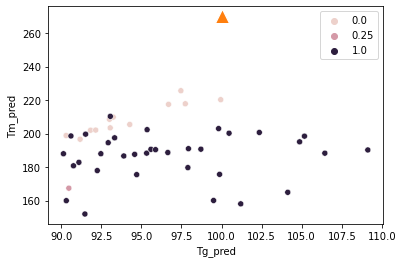

In [279]:
Tg_min = 90
Tg_max = 110

Tm_min = 140
Tm_max = 300

df_PS = df.copy()
df_PS = df_PS[
    (df_PS.Tg_pred > Tg_min)
    & (df_PS.Tg_pred < Tg_max)
    & (df_PS.Tm_pred > Tm_min)
    & (df_PS.Tm_pred < Tm_max)
    & ((df_PS.distribution == "[]") | (df_PS.distribution == "[0.5, 0.5]"))
]

sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_PS, legend=True, hue="pm")

# PVC
sns.scatterplot([100], [270], marker="^", s=200)

In [280]:
df_PS = df_PS.sort_values(by="distribution", ascending=False)

In [281]:
i = -1
good_monomers = set()

In [329]:
i += 1
monomers = [
    AllChem.MolFromSmiles(s) for s in get_mon_from_row(df_PS.iloc[i, :])
]
print(df_PS.iloc[i, [2, 3]])
AllChem.Draw.MolsToGridImage(monomers)

IndexError: single positional indexer is out-of-bounds

In [246]:
good_monomers.add(i)

In [248]:
df_

{0, 1, 2, 3, 4, 7, 9, 13, 14, 17}

In [249]:
good_monomers = {0, 1, 2, 3, 4, 7, 9, 13, 14, 17}

# Polymer Subsets

In [195]:
df_homo = df_agg[df_agg.distribution == "[]"]
df_co = df_agg[df_agg.distribution != "[]"]
df_homo_no_ring = df_homo[~df_homo.monomers.apply(has_int)]
df_homo_ring = df_homo[df_homo.monomers.apply(has_int)]

## Homopolymers

<AxesSubplot:xlabel='Tg_pred', ylabel='Tm_pred'>

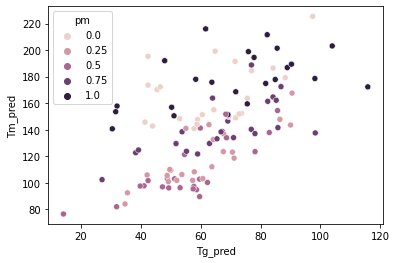

In [196]:
sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_homo_ring, hue="pm")

<AxesSubplot:xlabel='Tg_pred', ylabel='Tm_pred'>

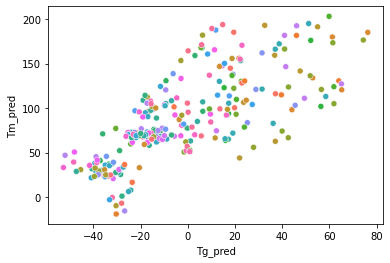

In [198]:
sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_homo_no_ring, hue="monomers", legend=False)

<AxesSubplot:xlabel='Tg_pred', ylabel='Tm_min_Tg'>

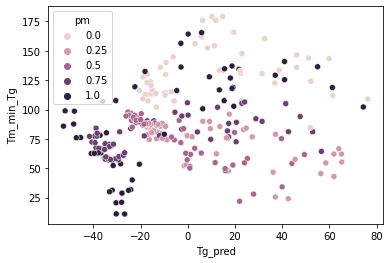

In [175]:
sns.scatterplot(x="Tg_pred", y="Tm_min_Tg", data=df_homo_no_ring, hue="pm")

<AxesSubplot:xlabel='pm', ylabel='Tm_pred'>

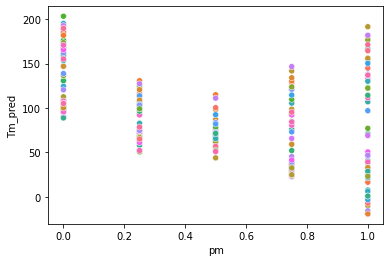

In [199]:
sns.scatterplot(x="pm", y="Tm_pred", data=df_homo_no_ring, hue="monomers", legend=False)
# TODO bottom right

In [250]:
df["gap"] = df.Tm_pred - df.Tg_pred

<AxesSubplot:xlabel='gap', ylabel='Count'>

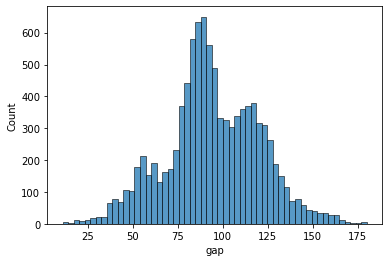

In [251]:
sns.histplot(x="gap", data=df)

<AxesSubplot:xlabel='gap', ylabel='pm'>

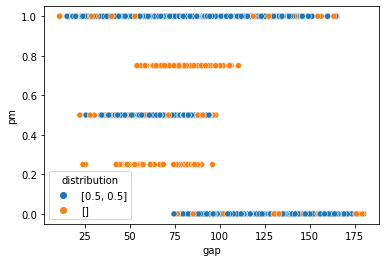

In [260]:
sns.scatterplot(x="gap", y="pm", data=df[df.num_missing <= 25], hue="distribution")

# Identify Tg Dependence

In [269]:
%%capture
def classify(monomer, df, prop):
    v0 = df[(df.monomers == monomer) & (df.pm == 0)].reset_index().loc[0, prop]
    v0_5 = df[(df.monomers == monomer) & (df.pm == 0.5)].reset_index().loc[0, prop]
    v1 = df[(df.monomers == monomer) & (df.pm == 1)].reset_index().loc[0, prop]
    print(v0, v0_5, v1)
    
    if v0 < v0_5 and v0_5 < v1:
        return "increasing"
    elif v0 > v0_5 and v0_5 > v1:
        return "decreasing"
    elif v0*0.95 < v1 and v0*1.05 > v1:
        return "constant"
    
monomers = list(set(df_homo.monomers))
monomers_trend = {m: classify(m, df_homo, "Tg_pred") for m in monomers}

In [270]:
df_trend = df_agg.merge(pd.DataFrame(monomers_trend.items(), columns=["monomers", "trend"]))

In [271]:
df_trend[df_trend.trend == "decreasing"].sort_values(by="Tg_pred", ascending=False).reset_index().loc[0, :].monomers

"('CC1(C)CCC=C(c2ccc(C(=O)O)cc2)[C@H]1O', 'CC1(C)CCC=C(c2ccc(C(=O)O)cc2)[C@@H]1O')"

<AxesSubplot:xlabel='pm', ylabel='Tm_pred'>

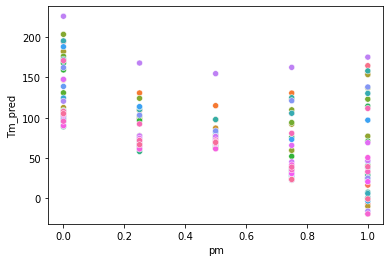

In [275]:
sns.scatterplot(x="pm", y="Tm_pred", data=df_trend[df_trend.trend == "decreasing"], hue="monomers", legend=False)

In [260]:
df_trend[df_trend.trend == "decreasing"].sort_values(by="Tg_pred", ascending=False).reset_index().head(5).loc[0, "monomers"]

"[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=O)C(=O)O'], ['O=C(O)[C@@]1(O)C=Cc2ccc3ccccc3c2O1', 'O=C(O)[C@]1(O)C=Cc2ccc3ccccc3c2O1']]"

In [267]:
m = df_trend[df_trend.trend == "decreasing"].sort_values(by="Tg_pred", ascending=False).reset_index().head(5).loc[0, "monomers"]
# classify(m, df_agg, "Tg_pred")
df_agg[df_agg.monomers == m]

,id,pm,distribution,monomers,DP,replicate_structure,Mn,Tm_pred,Tg_pred,kfold,Tm_min_Tg
1551,0da31ca5a806bc050b473f03dfc4a0dbebbe9736c65e23...,0.0,"[0.5, 0.5]","[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=...",25.0,2.0,1.0,189.387682,73.259492,5.0,116.128190
8697,4d42ff5d32cb2a2ce754cf3aaee2915ef3cdf1f0b36da3...,1.0,"[1, 0]","[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=...",25.0,2.0,1.0,136.690516,18.737146,5.0,117.953370
10826,60c1cda21e4f8071238358c448f60bdf8f43b72648358d...,0.5,"[0.5, 0.5]","[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=...",25.0,2.0,1.0,101.603459,46.341333,5.0,55.262126
11743,68e94cbd385af109817b17e2ea5ffac4b7f14e7abc464b...,0.0,"[1, 0]","[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=...",25.0,2.0,1.0,203.154906,59.857659,5.0,143.297247
15414,899090bb0783e3280a1166a2c7b0b7eeb841698ddccef4...,0.5,"[0, 1]","[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=...",25.0,2.0,1.0,99.971017,62.159760,5.0,37.811257
21005,ba943c4e5ddfeb43a0c913c0a6e491db6cbd7bcc4102e0...,1.0,"[0.5, 0.5]","[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=...",25.0,2.0,1.0,150.221168,71.922850,5.0,78.298317
22024,c33e411c114c822adfcee69f9be0276e8b8cf5f802c4d7...,0.0,"[0, 1]","[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=...",25.0,2.0,1.0,152.455155,73.656999,5.0,78.798155
22450,c70e80100e3b42dfce429db9df9172652fb6e665fb4b7a...,1.0,"[0, 1]","[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=...",25.0,2.0,1.0,172.220562,116.547661,5.0,55.672901
27735,f648ed8709064599f981e6c4a86ede195f4e1dcee78989...,0.5,"[1, 0]","[['CC[C@@](C)(O)C(=O)C(=O)O', 'CC[C@](C)(O)C(=...",25.0,2.0,1.0,78.559732,23.895966,5.0,54.663766


In [55]:
df_pred = pd.DataFrame(data=[[0, ], [2, 3]])
df_pred

,0,1
0,1,2
1,2,3
